## Set Up Flower Environment

In [1]:
#@test {"skip": true}
!pip install --quiet --upgrade flwr==1.0.0
!pip install --quiet --upgrade tensorflow-cpu==2.9.2
!pip install --quiet --upgrade pandas
!pip install --quiet --upgrade matplotlib

In [2]:
import collections
import os
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt

%matplotlib inline

2022-11-24 16:41:54.685541: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Dataset

This dataset is part of the [IEC 60870-5-104 Intrusion Detection Dataset](http://zenodo.org/record/7108614#.YzGaDtJBwUE) published by [ITHACA – University of Western Macedonia](http://ithaca.ece.uowm.gr/).

We input the dataset path and choose which dataset to facilitate for the experimentation.

In [3]:
path = '~/workspace/datasets/Balanced_IEC104_Train_Test_CSV_Files/iec104_train_test_csvs'
tp = 'custom'   # Type
tm = 180        # Time

Perform some value checks

In [4]:
assert tp in ('cic', 'custom'), "Wrong dataset type"
assert tm in (15, 30, 60, 90, 120, 180), "Wrong time"

In [5]:
dataset = f'tests_{tp}_{tm}'

if 'cic' in dataset:
    n = dataset.split('_')[-1]
    train_csv = os.path.join(os.path.join(path, dataset), f'train_{tm}_cicflow.csv')
    test_csv = os.path.join(os.path.join(path, dataset), f'test_{tm}_cicflow.csv')
elif 'custom' in dataset:
    n = dataset.split('_')
    train_csv = os.path.join(os.path.join(path, dataset), f'train_{tm}_custom_script.csv')
    test_csv = os.path.join(os.path.join(path, dataset), f'test_{tm}_custom_script.csv')
else:
    raise Exception("Wrong dataset")

df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(train_csv)

Let's perform some data exploration.

In [6]:
df_train.dtypes

flow idle time max                                 float64
flow idle time min                                 float64
flow idle time mean                                float64
flow idle time std                                 float64
flow idle time variance                            float64
                                                    ...   
type_id_system_information_in_monitor_direction      int64
type_id_system_information_in_control_direction      int64
type_id_parameter_in_control_direction               int64
type_id_file_transfer                                int64
Label                                               object
Length: 112, dtype: object

In [7]:
df_test.dtypes

flow idle time max                                 float64
flow idle time min                                 float64
flow idle time mean                                float64
flow idle time std                                 float64
flow idle time variance                            float64
                                                    ...   
type_id_system_information_in_monitor_direction      int64
type_id_system_information_in_control_direction      int64
type_id_parameter_in_control_direction               int64
type_id_file_transfer                                int64
Label                                               object
Length: 112, dtype: object

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Columns: 112 entries, flow idle time max to Label
dtypes: float64(48), int64(63), object(1)
memory usage: 3.1+ MB


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Columns: 112 entries, flow idle time max to Label
dtypes: float64(48), int64(63), object(1)
memory usage: 3.1+ MB


As a preprocessing step, we transorm the "Label" feature from string to categorical and then to numeric.

In [10]:
df_train['Label'] = df_train['Label'].str.lower()
df_test['Label'] = df_test['Label'].str.lower()

In [11]:
unique_labels = list(df_train.Label.astype('category').unique())
unique_codes = list(df_train.Label.astype('category').cat.codes.unique())
mapping = {unique_codes[i] : unique_labels[i] for i in range(len(unique_labels))}

In [12]:
mapping

{11: 'normal',
 0: 'c_ci_na_1',
 1: 'c_ci_na_1_dos',
 2: 'c_rd_na_1',
 3: 'c_rd_na_1_dos',
 4: 'c_rp_na_1',
 5: 'c_rp_na_1_dos',
 6: 'c_sc_na_1',
 7: 'c_sc_na_1_dos',
 8: 'c_se_na_1',
 9: 'c_se_na_1_dos',
 10: 'm_sp_na_1_dos'}

In [13]:
df_train['Label'] = df_train['Label'].replace(unique_labels, unique_codes)
df_test['Label'] = df_test['Label'].replace(unique_labels, unique_codes)

Now, we remove the features which do not assist with training a ML model.

In [14]:
if tp == 'cic':
    train = df_train.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp'])
    test = df_test.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp'])
else:
    train = df_train
    test = df_test

We rename the "Label" column to "y".

In [15]:
train.rename(columns={"Label": "y"}, inplace=True, errors="raise")
test.rename(columns={"Label": "y"}, inplace=True, errors="raise")
test.to_csv('test_data.csv')

We must use $N\geq2$ individual workers.

Each worker will be assigned a subset of the dataset with $\lfloor {M \over N} \rfloor$ data points.

Each worker data is storead as a seperate CSV file with the proper naming scheme.

In [16]:
n_workers = 2
n_samples = int(df_train.shape[0] / n_workers)

assert type(n_workers) == int, "Non-int number of workers"
assert n_workers >= 2, "At least 2 workers (docker containers) are required"
assert n_samples > 0, "Each worker must be assigned at least one data point"

client_data = []

for i in range(n_workers-1):
    sample = train.sample(n=n_samples)
    sample.to_csv(f'client_data_{i}.csv')
    df_train.drop(index=sample.index, inplace=True)
    client_data.append(sample)

sample = train.sample(n=n_samples)
sample.to_csv(f'client_data_{i+1}.csv')
client_data.append(sample)

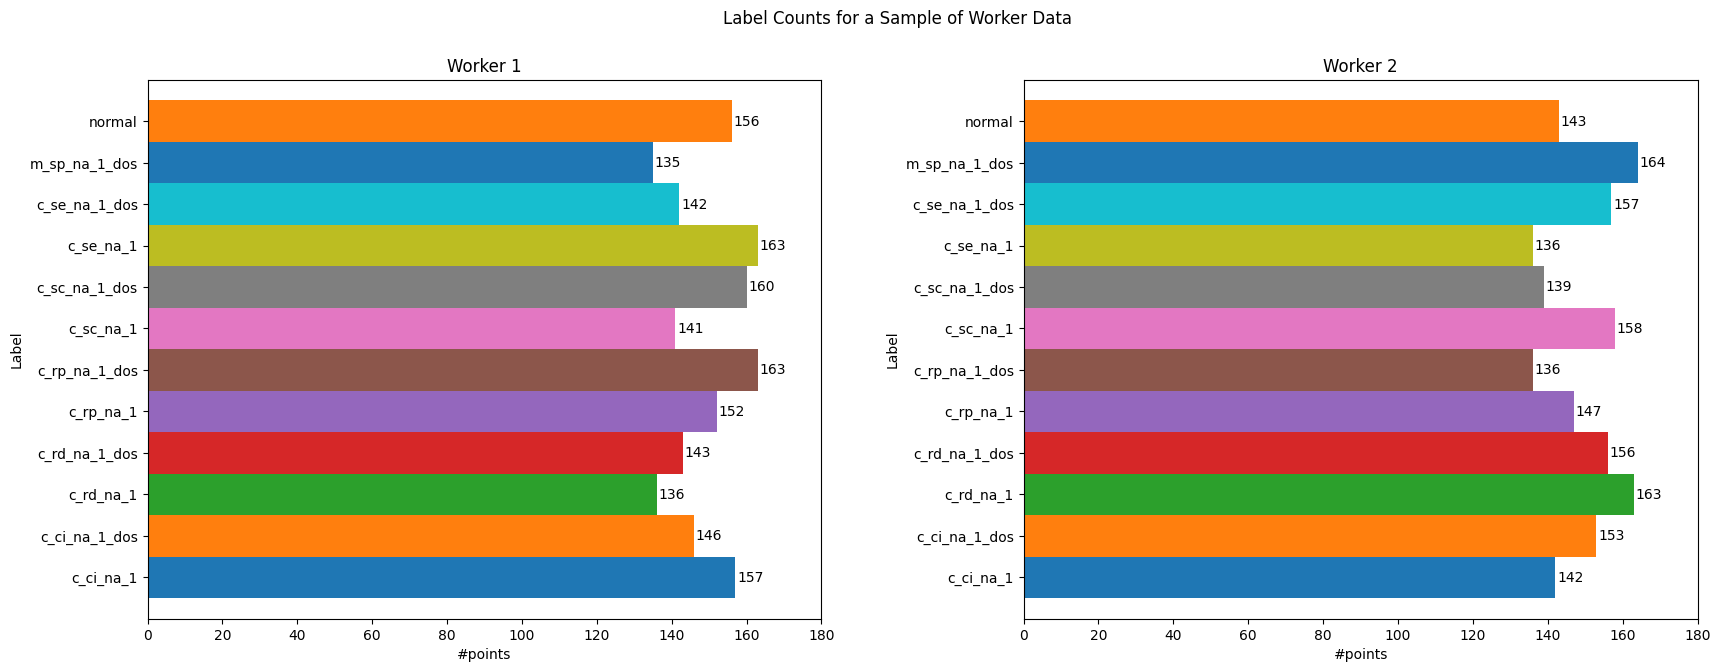

In [17]:
# Number of examples per layer for a sample of clients
fig = plt.figure(figsize=(20, 7))
fig.suptitle('Label Counts for a Sample of Worker Data')
fig.tight_layout()

for i in range(n_workers):
    m = 0
    plot_data = collections.defaultdict(list)
    sample = client_data[i]
    for label in sample['y']:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        plot_data[label].append(label)
        m = max(m, len(plot_data[label]))
    
    n_cols = n_workers if n_workers < 5 else 5
    xlim = [0, m+(20-m%20)]
    ylim = [min(unique_codes)-1, max(unique_codes)+1]
    yticks = list(range(min(unique_codes), max(unique_codes)+1))
    yticks_labels = [mapping[k] for k in range(0, max(unique_codes)+1)]
    
    plt.subplot(int(n_workers / 5)+1, n_cols, i+1)
    plt.subplots_adjust(wspace=0.3)
    plt.title('Worker {}'.format(i+1))
    plt.xlabel('#points')
    plt.xlim(xlim)
    plt.ylabel('Label')
    plt.ylim(ylim)
    plt.yticks(yticks, labels=yticks_labels)
    
    # plot values on top of bars
    for key in plot_data:
        if len(plot_data[key]) > 0:
            plt.text(len(plot_data[key])+4, int(key)-0.1, str(len(plot_data[key])), ha='center')
    
    for j in range(min(unique_codes),max(unique_codes)+1):
        plt.hist(
            plot_data[j],
            density=False,
            bins=[k-0.5 for k in range(min(unique_codes),max(unique_codes)+2)],
            orientation='horizontal'
        )